# Overview

In this notebook, I conduct the design of a user interface. The main goal of it is to interact with the interface for applying a hybrid model (SARIMAX + GRU) in order to predict the physical exercise adherence of the user/users desired. So, the user could look for their own physical exercise adherence data prediction and compare it with the adherence of the other users.

**Author**: Jon Maestre Escobar

**Email**: jonmaestre@opendeusto.es.

In [1]:
import pandas as pd
import numpy as np
import warnings
import pandas as pd
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import time
from utilities import Data_cleaning

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
import re
%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
df_filtered_merged = pd.read_hdf('../data/filtered_merged_dataset_v1.h5', key='df')
df_filtered_merged.fillna(0, inplace=True)
df_filtered_merged.shape

(46020, 8705)

---
## **GRU Model**

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Paso 1: Dividir los datos y normalizar
unique_users = df_filtered_merged['user_programs_user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# Crear datasets de entrenamiento y prueba basados en usuarios
train_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(train_users)]
test_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'].isin(test_users)]

# Agregación y normalización para el conjunto de entrenamiento
aggregated_train = train_data.groupby('user_programs_user_id').agg({
    'sum_of_reps': 'sum',
    'sum_of_time': 'sum',
    'total_count_of_series_reps': 'sum',
    'total_count_of_series_time': 'sum',
    'date': 'count'
}).reset_index()

aggregated_train = aggregated_train.rename(columns={'date': 'total_training_days'})

features_train = aggregated_train[['sum_of_reps', 'sum_of_time', 'total_count_of_series_reps',
                                   'total_count_of_series_time', 'total_training_days']].values
user_ids_train = aggregated_train['user_programs_user_id'].values

scaler = MinMaxScaler()
scaled_features_train = scaler.fit_transform(features_train)

# Paso 2: Crear y entrenar el modelo GRU
seq_length = 1
X_train = scaled_features_train.reshape((scaled_features_train.shape[0], seq_length, scaled_features_train.shape[1]))
y_train = features_train[:, 1]

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=32)

# Paso 3: Normalizar y predecir adherencia para todos los usuarios
all_users_data = df_filtered_merged.groupby('user_programs_user_id').agg({
    'sum_of_reps': 'sum',
    'sum_of_time': 'sum',
    'total_count_of_series_reps': 'sum',
    'total_count_of_series_time': 'sum',
    'date': 'count'
}).reset_index()

all_users_data = all_users_data.rename(columns={'date': 'total_training_days'})

features_all = all_users_data[['sum_of_reps', 'sum_of_time', 'total_count_of_series_reps',
                               'total_count_of_series_time', 'total_training_days']].values

scaled_features_all = scaler.transform(features_all)
X_all = scaled_features_all.reshape((scaled_features_all.shape[0], seq_length, scaled_features_all.shape[1]))

y_pred_all = model.predict(X_all)

# Paso 4: Calcular la adherencia
min_time = scaled_features_all[:, 1].min()
max_time = scaled_features_all[:, 1].max()

adherence_scores_all = (scaled_features_all[:, 1] - min_time) / (max_time - min_time)

thresholds = np.linspace(0, 1, 7)

adherence_levels_all = []
for score in adherence_scores_all:
    if score <= thresholds[1]:
        adherence_levels_all.append('Very Low')
    elif score <= thresholds[2]:
        adherence_levels_all.append('Low')
    elif score <= thresholds[3]:
        adherence_levels_all.append('Moderate')
    elif score <= thresholds[4]:
        adherence_levels_all.append('High')
    elif score <= thresholds[5]:
        adherence_levels_all.append('Very High')
    else:
        adherence_levels_all.append('Exceptional')

# Paso 5: Crear el DataFrame final para todos los usuarios
final_df_gru_all = pd.DataFrame({
    'user_id': all_users_data['user_programs_user_id'],
    'Adherence_Score': adherence_scores_all,
    'Adherence_Level': adherence_levels_all,
    'Adherence_Percentage': adherence_scores_all * 100,
    'Total_Reps': all_users_data['sum_of_reps'],
    'Total_Time': all_users_data['sum_of_time'],
    'Total_Series_Reps': all_users_data['total_count_of_series_reps'],
    'Total_Series_Time': all_users_data['total_count_of_series_time'],
    'Total_Training_Days': all_users_data['total_training_days']
})

# Mostrar la tabla resultante
print("Adherence data for all users:")
print(final_df_gru_all.head())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 50)          │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,901 (93.36 KB)

 Trainable params: 23,901 (93.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1406041600.0000
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1402447616.0000
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1423903872.0000
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1447415680.0000
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1568334848.0000
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1855239040.0000
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1659117312.0000
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1658936576.0000
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1543892352.0000
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1575631616.0000
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1650701440.0000
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1318050560.0000
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1439137280.0000
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━

---
## **User Interface (hybrid model SARIMAX + GRU)**

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=4429.287, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4457.558, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4429.589, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4435.552, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4461.920, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=4431.259, Time=0.10 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=4431.258, Time=0.09 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=4433.257, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=4433.607, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4427.615, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=4429.582, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4431.536, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=4429.204, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=4429.991, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[7]          

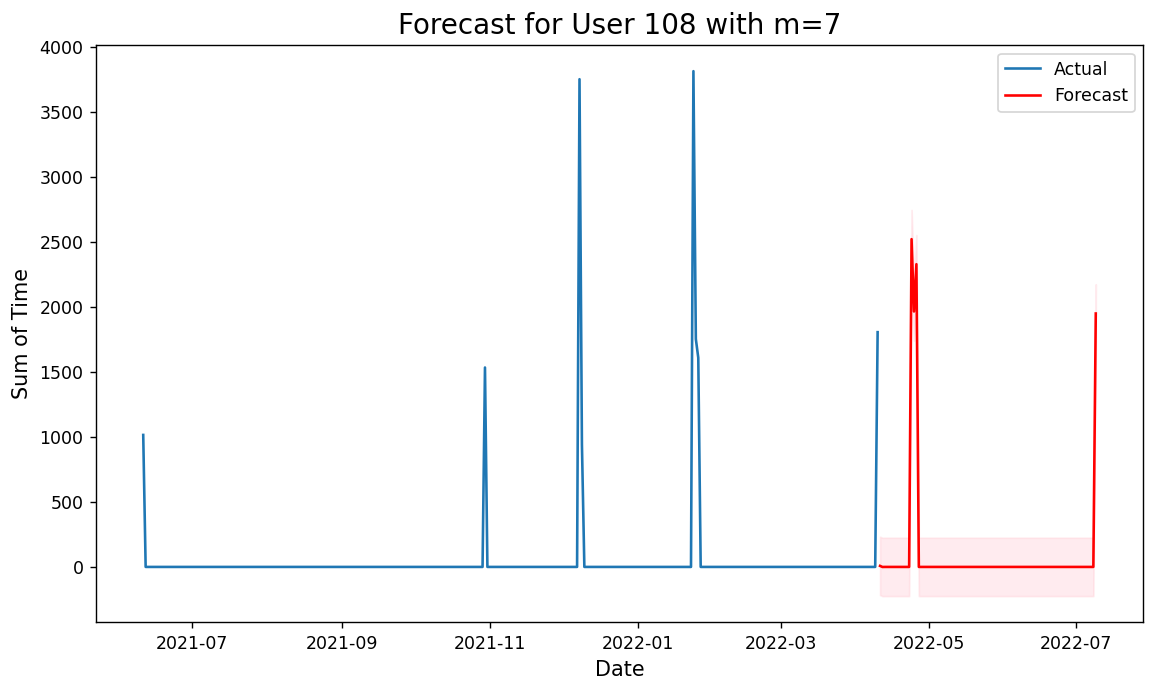

In [5]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example final_df_gru_all and df_filtered_merged
# final_df_gru_all = pd.DataFrame(...)
# df_filtered_merged = pd.DataFrame(...)

# Filter unique user data
unique_users = final_df_gru_all['user_id'].astype(str).tolist()

# Function to calculate adherence and display in a table
def calculate_adherence(user_id):
    user_data = final_df_gru_all[final_df_gru_all['user_id'] == int(user_id)]
    
    if user_data.empty:
        return None

    return user_data

# Function to predict and display the plots and adherence table
def predict_and_plot(user_id, content_frame):
    # Clear the previous content
    for widget in content_frame.winfo_children():
        widget.destroy()

    adherence_df = calculate_adherence(user_id)
    
    if adherence_df is None:
        label = tk.Label(content_frame, text=f"No data available for User ID {user_id}", font=('Arial', 14))
        label.pack(pady=20)
        return
    
    # Section for SARIMAX Model Results
    sarimax_title = tk.Label(content_frame, text="Best SARIMAX Model", font=('Arial', 16, 'bold'), bg='#F5F5F5', pady=10)
    sarimax_title.pack(fill=tk.X)

    sarimax_output = tk.Text(content_frame, height=10, wrap='word', font=('Courier', 10), bg="#F0F0F0", fg="#333")
    sarimax_output.pack(fill=tk.BOTH, expand=True, pady=10)

    # Filter training data for this user
    user_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'] == int(user_id)]
    user_data['date'] = pd.to_datetime(user_data['date'])
    user_data.set_index('date', inplace=True)
    user_data = user_data.sort_index()
    time_series_data = user_data['sum_of_time'].resample('D').sum()

    exog_reps = user_data['sum_of_reps'].resample('D').sum().fillna(0)
    exog_series_reps = user_data['total_count_of_series_reps'].resample('D').sum().fillna(0)
    exog_series_time = user_data['total_count_of_series_time'].resample('D').sum().fillna(0)
    exog_training_days = user_data.resample('D').size().fillna(0)

    exog_data = pd.concat([exog_reps, exog_series_reps, exog_series_time, exog_training_days], axis=1)

    time_series_data.index = pd.to_datetime(time_series_data.index)
    exog_data.index = pd.to_datetime(exog_data.index)
    time_series_data = time_series_data.dropna()

    m_values = [7, 30]  # weekly, monthly

    best_sarimax_model = None
    best_m = None

    for m in m_values:
        sarimax_output.insert(tk.END, f"\nTesting SARIMAX with m={m}\n")
        stepwise_model = auto_arima(time_series_data, start_p=1, start_q=1,
                                    max_p=10, max_q=10, seasonal=True,
                                    m=m,
                                    start_P=0, start_Q=0,
                                    max_P=2, max_Q=2, 
                                    max_d=2, max_D=2,
                                    exogenous=exog_data,
                                    trace=True, error_action='ignore', suppress_warnings=True,
                                    stepwise=True)
        if best_sarimax_model is None or stepwise_model.aic() < best_sarimax_model.aic():
            best_sarimax_model = stepwise_model
            best_m = m

    sarimax_output.insert(tk.END, f"\nBest SARIMAX model for User ID {user_id} with m={best_m}:\n")
    sarimax_output.insert(tk.END, best_sarimax_model.summary().as_text())

    best_order = best_sarimax_model.order
    best_seasonal_order = best_sarimax_model.seasonal_order

    model = SARIMAX(time_series_data, order=best_order, seasonal_order=best_seasonal_order, exog=exog_data)
    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=90, exog=exog_data[-90:])
    forecast_values = forecast.predicted_mean

    conf_int = forecast.conf_int()
    lower_bounds = conf_int.iloc[:, 0]
    upper_bounds = conf_int.iloc[:, 1]

    # Section for the prediction plot
    plot_title = tk.Label(content_frame, text="Forecast Plot", font=('Arial', 16, 'bold'), bg='#F5F5F5', pady=10)
    plot_title.pack(fill=tk.X)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time_series_data.index, time_series_data, label='Actual')
    ax.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
    ax.fill_between(forecast_values.index, lower_bounds, upper_bounds, color='pink', alpha=0.3)
    ax.set_title(f'Forecast for User {user_id} with m={best_m}', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Sum of Time', fontsize=12)
    ax.legend()

    canvas = FigureCanvasTkAgg(fig, master=content_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True, pady=10)

    # Section for the adherence table
    table_title = tk.Label(content_frame, text="Adherence Table", font=('Arial', 16, 'bold'), bg='#F5F5F5', pady=10)
    table_title.pack(fill=tk.X)

    table_frame = tk.Frame(content_frame, bg='#FFFFFF')
    table_frame.pack(fill=tk.BOTH, expand=True, pady=10)

    cols = list(adherence_df.columns)
    tree = ttk.Treeview(table_frame, columns=cols, show='headings', height=5)
    style = ttk.Style()
    style.configure("Treeview.Heading", font=('Arial', 12, 'bold'))
    style.configure("Treeview", font=('Arial', 10))

    for col in cols:
        tree.heading(col, text=col)
        tree.column(col, anchor=tk.CENTER, stretch=tk.YES, width=120)

    for index, row in adherence_df.iterrows():
        tree.insert("", "end", values=list(row))
    
    tree.pack(fill=tk.BOTH, expand=True)

# Create the main window
root = tk.Tk()
root.title("User Selection")
root.state('zoomed')  # Open the window maximized but not fullscreen (with the title bar)
root.configure(bg='#E0E0E0')

# Frame for the dropdown and buttons
frame_top = tk.Frame(root, bg='#E0E0E0')
frame_top.pack(side=tk.TOP, fill=tk.X, padx=20, pady=10)

# Frame for the scrollable content
scroll_canvas = tk.Canvas(root, bg='#F5F5F5')
scroll_canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

scrollbar = ttk.Scrollbar(root, orient="vertical", command=scroll_canvas.yview)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

scroll_canvas.configure(yscrollcommand=scrollbar.set)
scroll_canvas.bind('<Configure>', lambda e: scroll_canvas.configure(scrollregion=scroll_canvas.bbox("all")))

content_frame = tk.Frame(scroll_canvas, bg='#F5F5F5')
scroll_canvas.create_window((0, 0), window=content_frame, anchor="nw")

# Instruction label
label = tk.Label(frame_top, text="Select a User ID:", font=('Arial', 14), bg='#E0E0E0')
label.pack(side=tk.LEFT, padx=10)

# Create a dropdown with unique users
user_combobox = ttk.Combobox(frame_top, values=unique_users, state='readonly', width=30)
user_combobox.pack(side=tk.LEFT, padx=10)

# Analyze button
analyze_button = ttk.Button(frame_top, text="Analyze", command=lambda: predict_and_plot(user_combobox.get(), content_frame))
analyze_button.pack(side=tk.LEFT, padx=10)

# Exit button
exit_button = ttk.Button(frame_top, text="Exit", command=root.destroy)
exit_button.pack(side=tk.LEFT, padx=10)

root.mainloop()

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel, 
    QComboBox, QTextEdit, QScrollArea, QTableWidget, QTableWidgetItem, QSizePolicy, QHeaderView
)
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QFont
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Filter unique user data
unique_users = final_df_gru_all['user_id'].astype(str).tolist()

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None):
        self.fig, self.ax = plt.subplots()
        super().__init__(self.fig)
        self.setParent(parent)

class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        
        self.setWindowTitle("User Selection")
        self.showFullScreen()

        # Main layout
        main_widget = QWidget()
        main_layout = QVBoxLayout(main_widget)
        self.setCentralWidget(main_widget)

        # Top controls layout
        controls_layout = QHBoxLayout()
        main_layout.addLayout(controls_layout)

        label = QLabel("Select a User ID:")
        label.setFont(QFont('Arial', 14))
        controls_layout.addWidget(label)

        self.user_combobox = QComboBox()
        self.user_combobox.addItems(unique_users)
        self.user_combobox.setFixedWidth(200)
        controls_layout.addWidget(self.user_combobox)

        analyze_button = QPushButton("Analyze")
        analyze_button.clicked.connect(self.analyze)
        controls_layout.addWidget(analyze_button)

        exit_button = QPushButton("Exit")
        exit_button.clicked.connect(self.close)
        controls_layout.addWidget(exit_button)

        # Scrollable content area
        scroll_area = QScrollArea()
        scroll_area.setWidgetResizable(True)
        main_layout.addWidget(scroll_area)

        self.content_widget = QWidget()
        self.content_layout = QVBoxLayout(self.content_widget)
        scroll_area.setWidget(self.content_widget)

    def analyze(self):
        user_id = self.user_combobox.currentText()
        self.content_layout.setAlignment(Qt.AlignTop)

        # Clear previous content
        for i in reversed(range(self.content_layout.count())): 
            widget_to_remove = self.content_layout.itemAt(i).widget()
            self.content_layout.removeWidget(widget_to_remove)
            widget_to_remove.deleteLater()

        adherence_df = self.calculate_adherence(user_id)
        if adherence_df is None:
            label = QLabel(f"No data available for User ID {user_id}")
            label.setFont(QFont('Arial', 14))
            self.content_layout.addWidget(label)
            return

        # SARIMAX Model Output
        sarimax_title = QLabel("Best SARIMAX Model")
        sarimax_title.setFont(QFont('Arial', 16, QFont.Bold))
        sarimax_title.setAlignment(Qt.AlignCenter)
        self.content_layout.addWidget(sarimax_title)

        sarimax_output = QTextEdit()
        sarimax_output.setFont(QFont('Courier', 10))
        sarimax_output.setReadOnly(True)
        self.content_layout.addWidget(sarimax_output)

        # Filtering data
        user_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'] == int(user_id)]
        user_data['date'] = pd.to_datetime(user_data['date'])
        user_data.set_index('date', inplace=True)
        user_data = user_data.sort_index()
        time_series_data = user_data['sum_of_time'].resample('D').sum()

        exog_reps = user_data['sum_of_reps'].resample('D').sum().fillna(0)
        exog_series_reps = user_data['total_count_of_series_reps'].resample('D').sum().fillna(0)
        exog_series_time = user_data['total_count_of_series_time'].resample('D').sum().fillna(0)
        exog_training_days = user_data.resample('D').size().fillna(0)

        exog_data = pd.concat([exog_reps, exog_series_reps, exog_series_time, exog_training_days], axis=1)

        time_series_data.index = pd.to_datetime(time_series_data.index)
        exog_data.index = pd.to_datetime(exog_data.index)
        time_series_data = time_series_data.dropna()

        m_values = [7, 30]  # weekly, monthly

        best_sarimax_model = None
        best_m = None

        for m in m_values:
            sarimax_output.append(f"\nTesting SARIMAX with m={m}")
            stepwise_model = auto_arima(time_series_data, start_p=1, start_q=1,
                                        max_p=10, max_q=10, seasonal=True,
                                        m=m,
                                        start_P=0, start_Q=0,
                                        max_P=2, max_Q=2, 
                                        max_d=2, max_D=2,
                                        exogenous=exog_data,
                                        trace=True, error_action='ignore', suppress_warnings=True,
                                        stepwise=True)
            if best_sarimax_model is None or stepwise_model.aic() < best_sarimax_model.aic():
                best_sarimax_model = stepwise_model
                best_m = m

        sarimax_output.append(f"\nBest SARIMAX model for User ID {user_id} with m={best_m}:\n")
        sarimax_output.append(best_sarimax_model.summary().as_text())

        best_order = best_sarimax_model.order
        best_seasonal_order = best_sarimax_model.seasonal_order

        model = SARIMAX(time_series_data, order=best_order, seasonal_order=best_seasonal_order, exog=exog_data)
        result = model.fit(disp=False)

        forecast = result.get_forecast(steps=90, exog=exog_data[-90:])
        forecast_values = forecast.predicted_mean

        conf_int = forecast.conf_int()
        lower_bounds = conf_int.iloc[:, 0]
        upper_bounds = conf_int.iloc[:, 1]

        # Forecast Plot
        plot_title = QLabel("Forecast Plot")
        plot_title.setFont(QFont('Arial', 16, QFont.Bold))
        plot_title.setAlignment(Qt.AlignCenter)
        self.content_layout.addWidget(plot_title)

        canvas = MplCanvas(self)
        canvas.ax.plot(time_series_data.index, time_series_data, label='Actual')
        canvas.ax.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
        canvas.ax.fill_between(forecast_values.index, lower_bounds, upper_bounds, color='pink', alpha=0.3)
        canvas.ax.set_title(f'Forecast for User {user_id} with m={best_m}', fontsize=16)
        canvas.ax.set_xlabel('Date', fontsize=12)
        canvas.ax.set_ylabel('Sum of Time', fontsize=12)
        canvas.ax.legend()

        canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        canvas.updateGeometry()

        self.content_layout.addWidget(canvas)

        # Adherence Table
        table_title = QLabel("Adherence Table")
        table_title.setFont(QFont('Arial', 16, QFont.Bold))
        table_title.setAlignment(Qt.AlignCenter)
        self.content_layout.addWidget(table_title)

        table = QTableWidget()
        table.setRowCount(adherence_df.shape[0])
        table.setColumnCount(adherence_df.shape[1])
        table.setHorizontalHeaderLabels(adherence_df.columns)
        table.horizontalHeader().setSectionResizeMode(QHeaderView.Stretch)
        table.setSizeAdjustPolicy(QTableWidget.AdjustToContents)

        # Set column width equal and centered
        for i in range(adherence_df.shape[0]):
            for j in range(adherence_df.shape[1]):
                item = QTableWidgetItem(str(adherence_df.iat[i, j]))
                item.setTextAlignment(Qt.AlignCenter)
                table.setItem(i, j, item)

        table.horizontalHeader().setStretchLastSection(True)
        self.content_layout.addWidget(table)

    def calculate_adherence(self, user_id):
        user_data = final_df_gru_all[final_df_gru_all['user_id'] == int(user_id)]
        if user_data.empty:
            return None
        return user_data

if __name__ == "__main__":
    app = QApplication(sys.argv)
    main_win = MainWindow()
    main_win.showFullScreen()  # Ensure the window opens in fullscreen mode
    sys.exit(app.exec_())

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import (
    QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel, 
    QComboBox, QTextEdit, QScrollArea, QTableWidget, QTableWidgetItem, QSizePolicy, QHeaderView
)
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QFont
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example final_df_gru_all and df_filtered_merged
# final_df_gru_all = pd.DataFrame(...)
# df_filtered_merged = pd.DataFrame(...)

# Filter unique user data
unique_users = final_df_gru_all['user_id'].astype(str).tolist()

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None):
        self.fig, self.ax = plt.subplots()
        super().__init__(self.fig)
        self.setParent(parent)

class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        
        self.setWindowTitle("User Selection")
        self.showFullScreen()

        # Main layout
        main_widget = QWidget()
        main_layout = QVBoxLayout(main_widget)
        self.setCentralWidget(main_widget)

        # Top controls layout
        controls_layout = QHBoxLayout()
        main_layout.addLayout(controls_layout)

        label1 = QLabel("Select First User ID:")
        label1.setFont(QFont('Arial', 14))
        controls_layout.addWidget(label1)

        self.user_combobox1 = QComboBox()
        self.user_combobox1.addItems(unique_users)
        self.user_combobox1.setFixedWidth(200)
        controls_layout.addWidget(self.user_combobox1)

        label2 = QLabel("Select Second User ID:")
        label2.setFont(QFont('Arial', 14))
        controls_layout.addWidget(label2)

        self.user_combobox2 = QComboBox()
        self.user_combobox2.addItems(unique_users)
        self.user_combobox2.setFixedWidth(200)
        controls_layout.addWidget(self.user_combobox2)

        analyze_button = QPushButton("Analyze")
        analyze_button.clicked.connect(self.analyze)
        controls_layout.addWidget(analyze_button)

        exit_button = QPushButton("Exit")
        exit_button.clicked.connect(self.close)
        controls_layout.addWidget(exit_button)

        # Scrollable content area
        scroll_area = QScrollArea()
        scroll_area.setWidgetResizable(True)
        main_layout.addWidget(scroll_area)

        self.content_widget = QWidget()
        self.content_layout = QVBoxLayout(self.content_widget)
        scroll_area.setWidget(self.content_widget)

    def analyze(self):
        user_id1 = self.user_combobox1.currentText()
        user_id2 = self.user_combobox2.currentText()
        self.content_layout.setAlignment(Qt.AlignTop)

        # Clear previous content
        for i in reversed(range(self.content_layout.count())): 
            widget_to_remove = self.content_layout.itemAt(i).widget()
            self.content_layout.removeWidget(widget_to_remove)
            widget_to_remove.deleteLater()

        # Analyze and combine results
        adherence_df1, time_series_data1, forecast_values1, lower_bounds1, upper_bounds1, sarimax_text1 = self.analyze_user(user_id1, "User 1")
        adherence_df2, time_series_data2, forecast_values2, lower_bounds2, upper_bounds2, sarimax_text2 = self.analyze_user(user_id2, "User 2")

        # Combined SARIMAX Model Section
        sarimax_title = QLabel("Best SARIMAX Model Comparison")
        sarimax_title.setFont(QFont('Arial', 16, QFont.Bold))
        sarimax_title.setAlignment(Qt.AlignCenter)
        self.content_layout.addWidget(sarimax_title)

        sarimax_output = QTextEdit()
        sarimax_output.setFont(QFont('Courier', 10))
        sarimax_output.setReadOnly(True)
        sarimax_output.append(f"Best SARIMAX model for User 1 (User ID {user_id1}):\n")
        sarimax_output.append(sarimax_text1)
        sarimax_output.append("\n\n")
        sarimax_output.append(f"Best SARIMAX model for User 2 (User ID {user_id2}):\n")
        sarimax_output.append(sarimax_text2)
        self.content_layout.addWidget(sarimax_output)

        # Combined Forecast Comparison Plot
        plot_title = QLabel("Forecast Comparison Plot")
        plot_title.setFont(QFont('Arial', 16, QFont.Bold))
        plot_title.setAlignment(Qt.AlignCenter)
        self.content_layout.addWidget(plot_title)

        canvas = MplCanvas(self)
        canvas.ax.plot(time_series_data1.index, time_series_data1, label=f'Actual - User {user_id1}', color='blue')
        canvas.ax.plot(forecast_values1.index, forecast_values1, label=f'Forecast - User {user_id1}', color='red')
        canvas.ax.fill_between(forecast_values1.index, lower_bounds1, upper_bounds1, color='pink', alpha=0.3)

        canvas.ax.plot(time_series_data2.index, time_series_data2, label=f'Actual - User {user_id2}', color='green')
        canvas.ax.plot(forecast_values2.index, forecast_values2, label=f'Forecast - User {user_id2}', color='orange')
        canvas.ax.fill_between(forecast_values2.index, lower_bounds2, upper_bounds2, color='yellow', alpha=0.3)

        canvas.ax.set_title(f'Forecast Comparison for Users {user_id1} and {user_id2}', fontsize=16)
        canvas.ax.set_xlabel('Date', fontsize=12)
        canvas.ax.set_ylabel('Sum of Time', fontsize=12)
        canvas.ax.legend()

        canvas.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        canvas.updateGeometry()

        self.content_layout.addWidget(canvas)

        # Combined Adherence Table
        combined_df = pd.concat([adherence_df1, adherence_df2], keys=[f"User {user_id1}", f"User {user_id2}"]).reset_index(level=0).rename(columns={"level_0": "User"})
        table_title = QLabel("Adherence Table")
        table_title.setFont(QFont('Arial', 16, QFont.Bold))
        table_title.setAlignment(Qt.AlignCenter)
        self.content_layout.addWidget(table_title)

        table = QTableWidget()
        table.setRowCount(combined_df.shape[0])
        table.setColumnCount(combined_df.shape[1])
        table.setHorizontalHeaderLabels(combined_df.columns)
        table.horizontalHeader().setSectionResizeMode(QHeaderView.Stretch)
        table.setSizeAdjustPolicy(QTableWidget.AdjustToContents)

        for i in range(combined_df.shape[0]):
            for j in range(combined_df.shape[1]):
                item = QTableWidgetItem(str(combined_df.iat[i, j]))
                item.setTextAlignment(Qt.AlignCenter)
                table.setItem(i, j, item)

        table.horizontalHeader().setStretchLastSection(True)
        self.content_layout.addWidget(table)

    def analyze_user(self, user_id, user_label):
        adherence_df = self.calculate_adherence(user_id)
        if adherence_df is None:
            label = QLabel(f"No data available for {user_label} (User ID {user_id})")
            label.setFont(QFont('Arial', 14))
            self.content_layout.addWidget(label)
            return None, None, None, None, None, None

        # Filtering data
        user_data = df_filtered_merged[df_filtered_merged['user_programs_user_id'] == int(user_id)]
        user_data['date'] = pd.to_datetime(user_data['date'])
        user_data.set_index('date', inplace=True)
        user_data = user_data.sort_index()
        time_series_data = user_data['sum_of_time'].resample('D').sum()

        exog_reps = user_data['sum_of_reps'].resample('D').sum().fillna(0)
        exog_series_reps = user_data['total_count_of_series_reps'].resample('D').sum().fillna(0)
        exog_series_time = user_data['total_count_of_series_time'].resample('D').sum().fillna(0)
        exog_training_days = user_data.resample('D').size().fillna(0)

        exog_data = pd.concat([exog_reps, exog_series_reps, exog_series_time, exog_training_days], axis=1)

        time_series_data.index = pd.to_datetime(time_series_data.index)
        exog_data.index = pd.to_datetime(exog_data.index)
        time_series_data = time_series_data.dropna()

        m_values = [7, 30]  # weekly, monthly

        best_sarimax_model = None
        best_m = None

        sarimax_text = ""
        for m in m_values:
            sarimax_text += f"\nTesting SARIMAX with m={m}\n"
            stepwise_model = auto_arima(time_series_data, start_p=1, start_q=1,
                                        max_p=10, max_q=10, seasonal=True,
                                        m=m,
                                        start_P=0, start_Q=0,
                                        max_P=2, max_Q=2, 
                                        max_d=2, max_D=2,
                                        exogenous=exog_data,
                                        trace=True, error_action='ignore', suppress_warnings=True,
                                        stepwise=True)
            if best_sarimax_model is None or stepwise_model.aic() < best_sarimax_model.aic():
                best_sarimax_model = stepwise_model
                best_m = m

        sarimax_text += f"\nBest SARIMAX model for {user_label} (User ID {user_id}) with m={best_m}:\n"
        sarimax_text += best_sarimax_model.summary().as_text()

        best_order = best_sarimax_model.order
        best_seasonal_order = best_sarimax_model.seasonal_order

        model = SARIMAX(time_series_data, order=best_order, seasonal_order=best_seasonal_order, exog=exog_data)
        result = model.fit(disp=False)

        forecast = result.get_forecast(steps=90, exog=exog_data[-90:])
        forecast_values = forecast.predicted_mean

        conf_int = forecast.conf_int()
        lower_bounds = conf_int.iloc[:, 0]
        upper_bounds = conf_int.iloc[:, 1]

        return adherence_df, time_series_data, forecast_values, lower_bounds, upper_bounds, sarimax_text

    def calculate_adherence(self, user_id):
        user_data = final_df_gru_all[final_df_gru_all['user_id'] == int(user_id)]
        if user_data.empty:
            return None
        return user_data

if __name__ == "__main__":
    app = QApplication(sys.argv)
    main_win = MainWindow()
    main_win.showFullScreen()  # Ensure the window opens in fullscreen mode
    sys.exit(app.exec_())